In [1]:
import pandas
from itertools import product
import sys, argparse, os
import numpy as np
from math import log, ceil
from scipy.stats import multinomial, chi2
from math import factorial
import re
import os

In [2]:
from Bio import Phylo
from io import BytesIO     # for handling byte strings
from io import StringIO    # for handling unicode strings

## Define Bandelt_Node Class

In [3]:
class Bandelt_Node:
    def __init__(self, data):
        self.parent = None
        self.left = None
        self.right = None
        self.data = data
        
    def find_node(self, val):
        if self.data == val:
            return self
        else:
            if (self.left == None) and (self.right == None):
                return None
            if self.left != None:
                find_left = self.left.find_node(val)
                if find_left != None:
                    return find_left
            if self.right != None:
                find_right = self.right.find_node(val)
                if find_right != None:
                    return find_right
            return None
        
    def print_details(self):
        parent_data = self.parent.data if (self.parent != None) else self.parent
        left_data = self.left.data if (self.left != None) else self.left
        right_data = self.right.data if (self.right != None) else self.right
        print("Current Value: ", self.data, "; Parent: ", parent_data, "; left: ", left_data, "; right: ", right_data)
        
    def print_subtree(self, indent_num = 1):
        if indent_num == 1:
            print(self.data)
        if self.left != None:
            print('___'*indent_num, self.left.data)
            self.left.print_subtree(indent_num + 1)
        if self.right != None:
            print('___'*indent_num, self.right.data)
            self.right.print_subtree(indent_num + 1)
            
    def compare_subtree(self, compared_root_node):
        if self.data != compared_root_node.data:
#             print("Current number is not equal!")
            return False
        
        self_left_data = self.left.data if (self.left != None) else None
        self_right_data = self.right.data if (self.right != None) else None

        compared_root_node_left_data = compared_root_node.left.data if (compared_root_node.left != None) else None
        compared_root_node_right_data = compared_root_node.right.data if (compared_root_node.right != None) else None

        
        if (self_left_data in [compared_root_node_left_data, compared_root_node_right_data]) and (self_right_data in [compared_root_node_left_data, compared_root_node_right_data]):
#             print("Children are same !!")
            if (self_left_data == compared_root_node_left_data):
#                 print("Order are same !!")
                if self.left != None:
                    compare_ans_left = self.left.compare_subtree(compared_root_node.left)
                    if not compare_ans_left:
                        return False
                if self.right != None:
                    compare_ans_right = self.right.compare_subtree(compared_root_node.right)
                    if not compare_ans_right:
                        return False
                
            elif (self_left_data == compared_root_node_right_data):
#                 print("Order are not same !!")
                if self.left != None:
                    compare_ans_left = self.left.compare_subtree(compared_root_node.right)
                    if not compare_ans_left:
                        return False
                if self.right != None:
                    compare_ans_right = self.right.compare_subtree(compared_root_node.left)
                    if not compare_ans_right:
                        return False
        else:
#             print("Children are not same !!")
            return False
        return True

## Read files and get name mapping dictionary

In [4]:
folder_list = ['Bergsten_2013']

In [5]:
training_dataset_prefix = "../training_small"

In [6]:
dic={'A':'1', 'T':'2', 'C':'3', 'G':'4', '-':'0', '?':'0'}

In [7]:
mapping_dic_dic = {}

In [8]:
BRANCH_NUM = 100
SEQUENCE_LEN = 1000

In [9]:
# data preprocessing
for folder in folder_list:
    file_path = os.path.join(training_dataset_prefix, folder)
    files_list = os.listdir(file_path)
    for file in files_list:
        if file.find('.nex.treefile.dist') > 0:
            file_base_name = file[0:file.find('.nex.treefile.dist')]
            #######################
            # Input Processing !! #
            #######################
            print("****: ", file_base_name+'.nex')
            seq_data_raw = open(os.path.join(file_path, file_base_name+'.nex'))
            seq_data = seq_data_raw.readlines()[6:]
            species_mapping_dic = {}
            for idx, line in enumerate(seq_data):
                curr_line = line.split()
                if len(curr_line) < 2:
                    break
                print(curr_line[0])
                if int(idx) == 0:
                    species_mapping_dic[curr_line[0]] = sys.maxsize
                else: 
                    species_mapping_dic[curr_line[0]] = int(idx-1)
        mapping_dic_dic[file_base_name+'.nex'] = species_mapping_dic

****:  alignment_H3_3rdpos-out.nex
Andex_insignis
Canthyporus_hottentotus
Heterosternusa_pulcher
Hovahydrus_minutissimus
Hydrocolus_sahlbergi
Hydroporus_appalachius
Hydroporus_axillaris
Hydroporus_carri
Hydroporus_erythrocephalus
Hydroporus_fortis
Hydroporus_kraatzii
Hydroporus_lapponum
Hydroporus_longiusculus
Hydroporus_mannerheimi
Hydroporus_memnonius
Hydroporus_neglectus
Hydroporus_nigellus
Hydroporus_niger
Hydroporus_nigrita
Hydroporus_notabilis
Hydroporus_obscurus
Hydroporus_pilosus
Hydroporus_puberulus
Hydroporus_pubescens
Hydroporus_rufifrons
Hydroporus_scalesianus
Hydroporus_sinuatipes
Hydroporus_submuticus
Hydroporus_tessellatus
Hydroporus_tristis
Hydroporus_vagepictus
Hyphydrus_ovatus
Laccornellus_copelatoides
Neoporus_arizonicus
Neoporus_undulatus
Sanfilippodytes_terminalis
Suphrodytes_dorsalis
Suphrodytes_figuratus
****:  alignment_H3_2ndpos-out.nex
Andex_insignis
Canthyporus_hottentotus
Heterosternusa_pulcher
Hovahydrus_minutissimus
Hydrocolus_sahlbergi
Hydroporus_appalach

In [10]:
mapping_dic_dic

{'alignment_H3_3rdpos-out.nex': {'Andex_insignis': 9223372036854775807,
  'Canthyporus_hottentotus': 0,
  'Heterosternusa_pulcher': 1,
  'Hovahydrus_minutissimus': 2,
  'Hydrocolus_sahlbergi': 3,
  'Hydroporus_appalachius': 4,
  'Hydroporus_axillaris': 5,
  'Hydroporus_carri': 6,
  'Hydroporus_erythrocephalus': 7,
  'Hydroporus_fortis': 8,
  'Hydroporus_kraatzii': 9,
  'Hydroporus_lapponum': 10,
  'Hydroporus_longiusculus': 11,
  'Hydroporus_mannerheimi': 12,
  'Hydroporus_memnonius': 13,
  'Hydroporus_neglectus': 14,
  'Hydroporus_nigellus': 15,
  'Hydroporus_niger': 16,
  'Hydroporus_nigrita': 17,
  'Hydroporus_notabilis': 18,
  'Hydroporus_obscurus': 19,
  'Hydroporus_pilosus': 20,
  'Hydroporus_puberulus': 21,
  'Hydroporus_pubescens': 22,
  'Hydroporus_rufifrons': 23,
  'Hydroporus_scalesianus': 24,
  'Hydroporus_sinuatipes': 25,
  'Hydroporus_submuticus': 26,
  'Hydroporus_tessellatus': 27,
  'Hydroporus_tristis': 28,
  'Hydroporus_vagepictus': 29,
  'Hyphydrus_ovatus': 30,
  'La

## Run all tree examples

In [11]:
# for folder in folder_list:
#     file_path = os.path.join(training_dataset_prefix, folder)
#     files_list = os.listdir(file_path)
#     for file in files_list:
#         if file.find('.nex.treefile.dist') > 0:
#             file_base_name = file[0:file.find('.nex.treefile.dist')]
#             #######################
#             # Input Processing !! #
#             #######################
#             print("****: ", file_base_name+'.nex.treefile')
#             seq_data_raw = open(os.path.join(file_path, file_base_name+'.nex.treefile'))
#             seq_data = seq_data_raw.readline()
            

## Run one dictionary example

In [12]:
tree = Phylo.read(os.path.join(file_path, 'alignment_H3_3rdpos-out.nex.treefile'), 'newick')

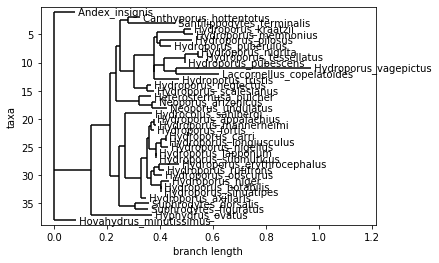

In [13]:
Phylo.draw(tree)

In [14]:
tree.root[0]

Clade(branch_length=0.0815684251, name='Andex_insignis')

In [15]:
tree.is_bifurcating()

True

In [16]:
len(tree.clade)

3

In [17]:
mapping_dic_dic['alignment_H3_3rdpos-out.nex']

{'Andex_insignis': 9223372036854775807,
 'Canthyporus_hottentotus': 0,
 'Heterosternusa_pulcher': 1,
 'Hovahydrus_minutissimus': 2,
 'Hydrocolus_sahlbergi': 3,
 'Hydroporus_appalachius': 4,
 'Hydroporus_axillaris': 5,
 'Hydroporus_carri': 6,
 'Hydroporus_erythrocephalus': 7,
 'Hydroporus_fortis': 8,
 'Hydroporus_kraatzii': 9,
 'Hydroporus_lapponum': 10,
 'Hydroporus_longiusculus': 11,
 'Hydroporus_mannerheimi': 12,
 'Hydroporus_memnonius': 13,
 'Hydroporus_neglectus': 14,
 'Hydroporus_nigellus': 15,
 'Hydroporus_niger': 16,
 'Hydroporus_nigrita': 17,
 'Hydroporus_notabilis': 18,
 'Hydroporus_obscurus': 19,
 'Hydroporus_pilosus': 20,
 'Hydroporus_puberulus': 21,
 'Hydroporus_pubescens': 22,
 'Hydroporus_rufifrons': 23,
 'Hydroporus_scalesianus': 24,
 'Hydroporus_sinuatipes': 25,
 'Hydroporus_submuticus': 26,
 'Hydroporus_tessellatus': 27,
 'Hydroporus_tristis': 28,
 'Hydroporus_vagepictus': 29,
 'Hyphydrus_ovatus': 30,
 'Laccornellus_copelatoides': 31,
 'Neoporus_arizonicus': 32,
 'Neop

In [18]:
def create_Bandelt_Tree(clade, parent_node):
    for idx in range(len(clade)):
        if idx == 0:
            if clade[idx].is_terminal():
                children_node = Bandelt_Node(int(mapping_dic_dic['alignment_H3_3rdpos-out.nex'][clade[idx].name]))
#                 # Parent add 
                parent_node.left = children_node
                children_node.parent = parent_node
#                 print(clade[idx].name)
            else:
                children_node = Bandelt_Node(int(-100))
                parent_node.left = children_node
                children_node.parent = parent_node
#                 print(clade[idx])
        if idx == 1:  
            if clade[idx].is_terminal():
                children_node = Bandelt_Node(int(mapping_dic_dic['alignment_H3_3rdpos-out.nex'][clade[idx].name]))
#                 # Parent add 
                parent_node.right = children_node
                children_node.parent = parent_node
#                 print(clade[idx].name)
            else:
                children_node = Bandelt_Node(int(-100))
                parent_node.right = children_node
                children_node.parent = parent_node
#                 print(clade[idx])
        create_Bandelt_Tree(clade[idx], children_node)

In [19]:
def find_Bandelt_encode(target_node, val):
    visited_nodes = []
    queue = []
    visited_nodes.append(target_node.data)
    queue.append(target_node)
    encode_num = None
    while queue:
        current_node = queue.pop(0)
        if current_node != None:
#             print ("**** current_node: ", current_node.data) 
            if current_node.data != '*' and abs(int(current_node.data)) < abs(int(val)):
                encode_num = current_node.data
        if current_node.left != None:
            if current_node.left.data not in visited_nodes:
                visited_nodes.append(current_node.left.data)
                queue.append(current_node.left)
                
        if current_node.right != None:
            if current_node.right.data not in visited_nodes:
                visited_nodes.append(current_node.right.data)
                queue.append(current_node.right)   
        if encode_num != None:
            break
    return encode_num

In [20]:
for idx in range(len(tree.root)):
    if (tree.root[idx].name != None) and (mapping_dic_dic['alignment_H3_3rdpos-out.nex'][tree.root[idx].name] == sys.maxsize):
        # This is the root
        root_node = Bandelt_Node(sys.maxsize)
#         print(tree.root[idx].name)
    if tree.root[idx].name == None:
        # This is the inner root
        inner_root = Bandelt_Node(-100)
        inner_clade = tree.root[idx]
#         print(tree.root[idx].name)
    if (tree.root[idx].name != None) and (mapping_dic_dic['alignment_H3_3rdpos-out.nex'][tree.root[idx].name] != sys.maxsize):
        # This is the first layer node
#         print("This is the first layer node")
        first_node = Bandelt_Node(mapping_dic_dic['alignment_H3_3rdpos-out.nex'][tree.root[idx].name])
#         print(tree.root[idx].name)
# Add linkage for the first three node
root_node.left = inner_root
inner_root.parent = root_node

inner_root.left = first_node
first_node.parent = inner_root

second_inner_node = Bandelt_Node(-100)

inner_root.right = second_inner_node
second_inner_node.parent = inner_root

In [21]:
root_node.print_subtree()

9223372036854775807
___ -100
______ 2
______ -100


In [22]:
create_Bandelt_Tree(inner_clade, second_inner_node)

In [23]:
root_node.print_subtree()

9223372036854775807
___ -100
______ 2
______ -100
_________ -100
____________ -100
_______________ -100
__________________ -100
_____________________ 0
_____________________ 34
__________________ -100
_____________________ -100
________________________ -100
___________________________ -100
______________________________ 9
______________________________ 13
___________________________ -100
______________________________ 20
______________________________ 21
________________________ -100
___________________________ -100
______________________________ -100
_________________________________ -100
____________________________________ 17
____________________________________ 27
_________________________________ 22
______________________________ -100
_________________________________ 29
_________________________________ 31
___________________________ 28
_____________________ -100
________________________ 14
________________________ 24
_______________ -100
__________________ 1
__________________ -

In [24]:
def inner_node_indexation(current_node):
#     print(current_node.data)
    if current_node.left != None:
        left_data = inner_node_indexation(current_node.left)
    if current_node.right != None:
        right_data = inner_node_indexation(current_node.right)
    
    if current_node.left != None and current_node.right != None:
        # This is the inner node
        if len(left_data) == 0:
            current_node.data = int(-right_data[0])
            return []
        if len(right_data) == 0:
            current_node.data = int(-left_data[0])
            return []
        if len(left_data) != 0 and len(right_data) != 0:
            if abs(left_data[0]) > abs(right_data[0]):
                current_node.data = int(-left_data[0])
                return [right_data[0]]
            elif abs(left_data[0]) < abs(right_data[0]):
                current_node.data = int(-right_data[0])
                return [left_data[0]]
    elif current_node.left != None and current_node.right == None:
        print("Finish!")
    else:
        # This is the terminal node
        return [current_node.data]
#     if current_node.left == None and current_node.right == None:     
# #         # This node is the terminal vertex
#         return str(current_node.data)

#     if current_node.left != None and current_node.right != None:
#         newick_string = '(' + left_newick_string + ',' + right_newick_string + ')' + str(current_node.data)


In [25]:
inner_node_indexation(root_node)

Finish!


In [26]:
root_node.print_subtree()

9223372036854775807
___ -2
______ 2
______ -30
_________ -3
____________ -1
_______________ -9
__________________ -34
_____________________ 0
_____________________ 34
__________________ -14
_____________________ -17
________________________ -20
___________________________ -13
______________________________ 9
______________________________ 13
___________________________ -21
______________________________ 20
______________________________ 21
________________________ -28
___________________________ -29
______________________________ -22
_________________________________ -27
____________________________________ 17
____________________________________ 27
_________________________________ 22
______________________________ -31
_________________________________ 29
_________________________________ 31
___________________________ 28
_____________________ -24
________________________ 14
________________________ 24
_______________ -32
__________________ 1
__________________ -33
___________________

In [27]:
def Bandelt_Encode(root_node):
    encode_num_list = []
    for i in range(0, tree.count_terminals()-2):
        target_node_val = -(i+1)
        found_node = root_node.find_node(target_node_val)
#         print(found_node.print_details(), '\n')
        encode_num = find_Bandelt_encode(found_node, target_node_val)
        encode_num_list.append(encode_num)
    return (root_node, encode_num_list)

In [28]:
encode_tree, bandelt_encode_num = Bandelt_Encode(root_node)

In [29]:
encode_tree.print_subtree()

9223372036854775807
___ -2
______ 2
______ -30
_________ -3
____________ -1
_______________ -9
__________________ -34
_____________________ 0
_____________________ 34
__________________ -14
_____________________ -17
________________________ -20
___________________________ -13
______________________________ 9
______________________________ 13
___________________________ -21
______________________________ 20
______________________________ 21
________________________ -28
___________________________ -29
______________________________ -22
_________________________________ -27
____________________________________ 17
____________________________________ 27
_________________________________ 22
______________________________ -31
_________________________________ 29
_________________________________ 31
___________________________ 28
_____________________ -24
________________________ 14
________________________ 24
_______________ -32
__________________ 1
__________________ -33
___________________

In [30]:
def post_order_traversal(current_node):
#     print(current_node.data)
    if current_node.left != None:
        left_newick_string = post_order_traversal(current_node.left)
    if current_node.right != None:
        right_newick_string = post_order_traversal(current_node.right)

    if current_node.left == None and current_node.right == None:     
#         # This node is the terminal vertex
        return str(current_node.data)

    if current_node.left != None and current_node.right != None:
        newick_string = '(' + left_newick_string + ',' + right_newick_string + ')' + str(current_node.data)
    return newick_string

In [31]:
def Bandelt_Decode(Bandelt_Encode_list):
    BANDELT_NUM = len(Bandelt_Encode_list)
    # Initial with three nodes
    root_node = Bandelt_Node(sys.maxsize)
    node_1 = Bandelt_Node(1)
    node_neg_1 = Bandelt_Node(-1)
    node_0 = Bandelt_Node(0)
    # Create links between initial three nodes
    root_node.left = node_neg_1
    node_neg_1.parent = root_node
    node_neg_1.left = node_0
    node_neg_1.right = node_1
    node_1.parent = node_neg_1
    node_0.parent = node_neg_1
    
    for i in range(1, BANDELT_NUM):
        added_node_val = -(i+1)
#         print('Node going to be added: ', added_node_val)
#         print('Need to find: ', Bandelt_Encode_list[i], ' node')

        added_node_neg = Bandelt_Node(added_node_val)
        added_node_pos = Bandelt_Node(-added_node_val)

        target_node = root_node.find_node(Bandelt_Encode_list[i])

        # If target node is the left child 
        if target_node.parent.left == target_node:
            target_node.parent.left = added_node_neg
            added_node_neg.parent = target_node.parent
            added_node_neg.left = target_node
            target_node.parent = added_node_neg

            added_node_neg.right = added_node_pos
            added_node_pos.parent = added_node_neg

        # If target node is the right child
        if target_node.parent.right == target_node:
            target_node.parent.right = added_node_neg
            added_node_neg.parent = target_node.parent
            added_node_neg.right = target_node
            target_node.parent = added_node_neg

            added_node_neg.left = added_node_pos
            added_node_pos.parent = added_node_neg
    decode_tree = post_order_traversal(root_node.left)
    decode_tree_newick = decode_tree + ';'
    return (root_node, decode_tree_newick)

In [35]:
bandelt_encode_num

[0,
 -1,
 -1,
 3,
 4,
 4,
 -6,
 4,
 0,
 6,
 6,
 4,
 9,
 -13,
 -11,
 7,
 -13,
 16,
 7,
 -13,
 20,
 17,
 7,
 14,
 18,
 10,
 17,
 -22,
 -22,
 -3,
 29,
 1,
 32,
 0,
 -4,
 35]

In [32]:
decode_tree, bandelt_decode_num = Bandelt_Decode(bandelt_encode_num)

In [33]:
decode_tree.print_subtree()

9223372036854775807
___ -2
______ -30
_________ -3
____________ -1
_______________ -9
__________________ -34
_____________________ 0
_____________________ 34
__________________ -14
_____________________ -24
________________________ 14
________________________ 24
_____________________ -17
________________________ -28
___________________________ -29
______________________________ -22
_________________________________ -27
____________________________________ 17
____________________________________ 27
_________________________________ 22
______________________________ -31
_________________________________ 31
_________________________________ 29
___________________________ 28
________________________ -20
___________________________ -21
______________________________ 20
______________________________ 21
___________________________ -13
______________________________ 13
______________________________ 9
_______________ -32
__________________ -33
_____________________ 32
_____________________ 33

In [34]:
decode_tree.compare_subtree(encode_tree)

True